<div class="alert alert-info">

<h4> Домашнее задание. Выполнять в отдельном файле, в названии указать фамилию и название работы</h4>
<p></p>

С помощью LinearRegression построить две модели SARIMA для своего временного ряда: 
<li>полученную при выполнении задания "5. Построение модели SARIMAX" и </li>
<li>полученную с помощью функции TimeSeriesModelFit в Mathematica.</li>
    
Для этого создать матрицу объекты-признаки, которая будет состоять из "сдвинутых" на нужное количество лагов значений. Оценить качество обеих моделей методом кросс-валидации на временных рядах (TimeSeriesSplit + cross_val_score) с метрикой MSE или MAE.
    
**Задание для всех**: для простоты построить только модели авторегрессии с обычными и сезонными лагами.
    
**Указание**: если модели из statsmodels и Mathematica совпадают, взять вторую модель чуть большего порядка, чем первая.

<p></p>
</div>

[HT 5. Построение модели SARIMAX](https://github.com/aptmess/methods-of-forecasting/blob/master/hometasks/ht6/sarimax_ht_shirokov.ipynb)

## 1 Визуализация ряда

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
import warnings
import glob

In [2]:
directory = 'data/*.csv' 
files = glob.glob(directory)[0]

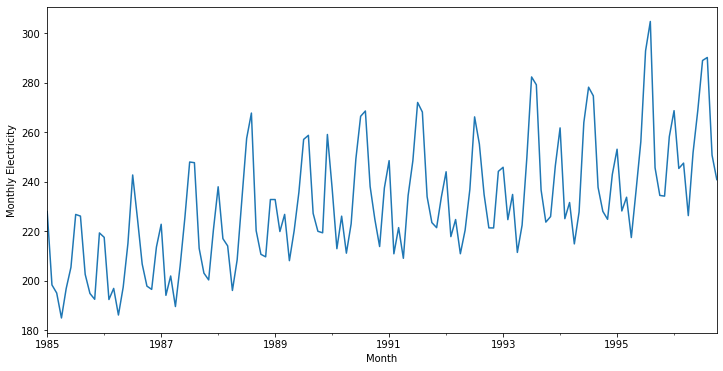

In [3]:
df = wine = pd.read_csv(files, index_col=['Month'], parse_dates=['Month'], dayfirst=True)
df.columns  = ['elctricty']
df['elctricty'].plot(figsize=(12,6))
plt.ylabel('Monthly Electricity')
plt.show()

## 2 My SARIMA 

`p, d, q = 0, 1, 2`

`P, D, Q = 2, 1, 1`

In [4]:
'''Столбцы матрицы признаков'''
df['X']=np.arange(0,df.shape[0])
X_p = df.X.shift(0).values; #0
X_d = df.X.diff(12) #diff
X_q = df.X.shift(24).values; #q
X_P = df.elctricty.shift(24).values; #P
X_D = df.X.diff(12) #diff
X_Q = df.elctricty.shift(12).values ; #Q

In [5]:
'''собираем матрицу признаков'''
_X1 = np.nan_to_num(np.concatenate((X_p,X_d,X_q,X_P,X_D,X_Q)).reshape(6,142).T,0)

In [6]:
'''обучаем модель'''
from sklearn.linear_model import LinearRegression
_m1 = LinearRegression()

y = df.elctricty.values

_m1.fit(_X1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
from sklearn.metrics import mean_squared_error as MSE,\
mean_absolute_error as MAE, explained_variance_score as R2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [8]:
time = df.X.values
n = 13

_tm1 = _m1.predict(_X1)[n:],y[n:]

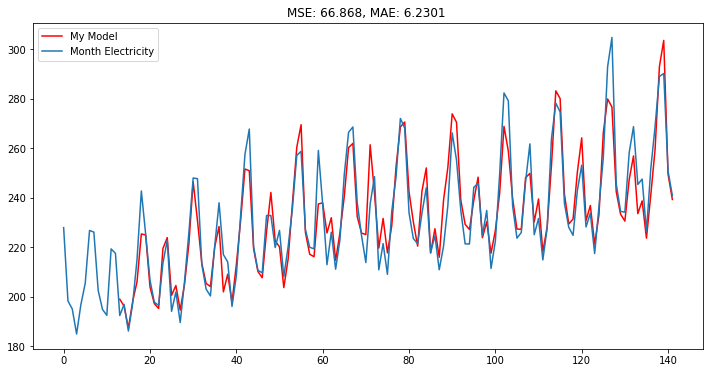

In [9]:
'''график'''
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(time[n:], _tm1[0] , label='My Model', color = 'r')
plt.plot(time, y, label='Month Electricity')
plt.legend()
plt.title(f'MSE: {MSE(*_tm1):.5}, MAE: {MAE(*_tm1):.5} ')
plt.show()

### 2.1 Оценка качества

In [10]:
MSE(*_tm1),MAE(*_tm1),R2(*_tm1)

(66.8677512623726, 6.230132211824173, 0.8654663282007746)

In [11]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=100)
_rmse1 = cross_val_score(_m1, _X1, y, scoring='neg_mean_squared_error', cv=tss).mean()
_rmse1

-82.73883795427393

In [12]:
_rmae1 = cross_val_score(_m1, _X1, y, scoring='neg_mean_absolute_error', cv=tss).mean()
_rmae1

-6.785874931235281

## 3 `TimeSeriesModelFit` SARIMA

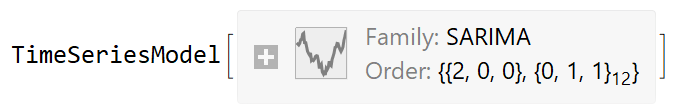

`p, d, q = 2, 0, 0`

`P, D, Q = 0, 1, 1`

In [13]:
'''Столбцы матрицы признаков'''
X_p = df.X.shift(2).values; #0
X_d = df.X #no diff
X_q = df.X.shift().values; #q
X_P = df.elctricty.shift().values; #P
X_D = df.X.diff(12) #diff
X_Q = df.elctricty.shift(12).values ; #Q

In [14]:
'''собираем матрицу признаков'''
_X2 = np.nan_to_num(np.concatenate((X_p,X_d,X_q,X_P,X_D,X_Q)).reshape(6,142).T,0)

In [15]:
'''обучаем модель'''
from sklearn.linear_model import LinearRegression
_m2 = LinearRegression()

y = df.elctricty.values

_m2.fit(_X2 , y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
time = df.X.values
n = 13

_tm2 = _m2.predict(_X2)[n:],y[n:]

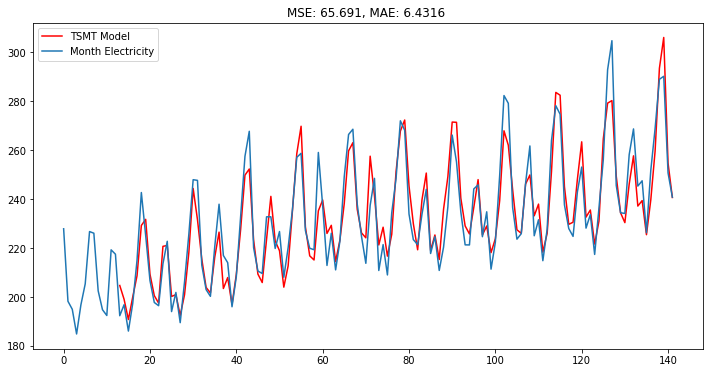

In [17]:
'''график'''
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(time[n:], _tm2[0] , label='TSMT Model', color = 'r')
plt.plot(time, y, label='Month Electricity')
plt.legend()
plt.title(f'MSE: {MSE(*_tm2):.5}, MAE: {MAE(*_tm2):.5} ')
plt.show()

### 3.1 Оценка качества

In [18]:
MSE(*_tm2),MAE(*_tm2),R2(*_tm2)

(65.69095773036486, 6.4315736257823986, 0.8683302008171846)

In [19]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=100)
_rmse2 = cross_val_score(_m2, _X2, y, scoring='neg_mean_squared_error', cv=tss).mean()
_rmse2

-85.76643636812767

In [20]:
_rmae2 = cross_val_score(_m2, _X2, y, scoring='neg_mean_absolute_error', cv=tss).mean()
_rmae2

-7.163975367026474

In [21]:
core_res = pd.DataFrame({'MSE KFold':(_rmse1,_rmse2),'MAE KFold':(_rmae1,_rmae2)},\
                        index = ['MySarima','TSMT Sarima'])
core_res

,MSE KFold,MAE KFold
MySarima,-82.738838,-6.785875
TSMT Sarima,-85.766436,-7.163975


По данным таблицы видно, что MySaRima работает лучше, если я правильно понял фразу:

`'чем больше значение метрики качества, тем лучше.`